In [1]:
%matplotlib inline
import os
from Bio import SeqIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio.SeqUtils.ProtParam import ProteinAnalysis
#from Bio.SeqUtils import ProtParam
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import accuracy_score
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
from sklearn import preprocessing

# data directory

#dirz = os.getcwd()
dirz = ''
blind_DIR = os.path.join(dirz,'data', 'blind.fasta')
cyto_DIR = os.path.join(dirz,'data', 'cyto.fasta')
mito_DIR = os.path.join(dirz,'data', 'mito.fasta')
nucleus_DIR = os.path.join(dirz,'data', 'nucleus.fasta')
secreted_DIR = os.path.join(dirz,'data', 'secreted.fasta')

def loadData(fileDir):
    seq_id = []
    seq = []
    seq_num = []
    for seq_record in SeqIO.parse(fileDir, "fasta"):
        seq_id.append(seq_record.id)
        seq.append(str(seq_record.seq))
        seq_num.append(len(seq_record))
    d = {'seq':seq}
    dffasta = pd.DataFrame(data=d,index=seq_id)
    return dffasta

#data process
#load data
blind = loadData(blind_DIR)
cyto = loadData(cyto_DIR)
mito = loadData(mito_DIR)
nucleus = loadData(nucleus_DIR)
secreted = loadData(secreted_DIR)




/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def addLabels(df,label):
    col1 = np.ones(len(df),dtype=int)
    col0 = np.zeros(len(df),dtype=int)
    if label=='cyto':
        df = df.assign(cyto=col1)
    else:
        df = df.assign(cyto=col0)
    if label=='mito':
        df = df.assign(mito=col1)
    else:
        df = df.assign(mito=col0)
    if label=='nucleus':
        df = df.assign(nucleus=col1)
    else:
        df = df.assign(nucleus=col0)
    if label=='secreted':
        df = df.assign(secreted=col1)
    else:
        df = df.assign(secreted=col0)
    
    return df

#add labels
dfcyto = cyto.assign(label=len(cyto)*[0])#addLabels(cyto,'cyto')
dfmito = mito.assign(label=len(mito)*[1])#addLabels(mito,'mito')
dfnucleus = nucleus.assign(label=len(nucleus)*[2])#addLabels(nucleus,'nucleus')
dfsecreted = secreted.assign(label=len(secreted)*[3])#addLabels(secreted,'secreted')

frame = [dfcyto,dfmito,dfnucleus,dfsecreted]
data = pd.concat(frame)
#clean data
seq = data['seq']
def replace_aminoacid(seq):
    seq2 = []
    for i in range(len(seq)):
        s = seq[i]
        s = s.replace('X','')
        s = s.replace('U','')
        s = s.replace('O','')
        s = s.replace('B','N')
        s = s.replace('Z','Q')
        s = s.replace('J','L')
        seq2.append(s)
    return seq2
seq2 = replace_aminoacid(seq)  
data = data.assign(seq2=seq2) 



In [3]:
#add features
def getLen(seq):
    #seq = data['seq']
    l = [len(i) for i in seq]
    return l 

def getProb(data,seq,colname,begin,end):
    ss=''
    for i in seq:
        ss = ss+i[begin:end]
    aminoAcidList = list(set(ss))
    #print(len(aminoAcidList))
    count_amino = {}
    for a in aminoAcidList:
        comp = [i[begin:end].count(a)/len(i[begin:end]) for i in seq]
        colName = colname+a
        #if begin==None:
         #   count_amino[colName] = comp/data['seq_num']
        #else:
        count_amino[colName] = comp
    prob = pd.DataFrame(count_amino,index=data.index) #!!!
    data = data.join(prob)
    return data


def calcproperty(p,pl,seq,property_value):
    degree = ['p','n','h']
    for i in range(len(degree)):
        amino = pl[i]
        col = p+degree[i]
        property_value[col] = []
        for s in seq:
            property_value[col].append(np.sum([s.count(a) for a in amino])/len(s))



seq2 = data['seq2']
data_features = data.assign(seq_num=getLen(seq2))    
data_features = getProb(data_features,seq2,'p_',None,None)
data_features = getProb(data_features,seq2,'pf50_',0,50)
data_features = getProb(data_features,seq2,'pb50_',-50,None)


molecular_weight = [ProteinAnalysis(s).molecular_weight() for s in seq2]
isoelectric_point = [ProteinAnalysis(s).isoelectric_point() for s in seq2]
aromaticity = [ProteinAnalysis(s).aromaticity() for s in seq2]
hydrophobicity = [ProteinAnalysis(s).gravy() for s in seq2]
#flexibility = [ProteinAnalysis(s).flexibility() for s in seq2]
data_features = data_features.assign(molecular_w=molecular_weight)
data_features = data_features.assign(isoelectric_p=isoelectric_point)
data_features = data_features.assign(aromaticity=aromaticity)
data_features = data_features.assign(hydrophobicity=hydrophobicity)


second_helix = []
second_turn = []
second_sheet = []
pct_pos_charged = []
pct_neg_charged = []
pct_hydrophobic = []
nvw_p = 'normalized_vander_Waals'  
nvw_pl = [['G','A','S','C','T','P','D'],['N','V','E','Q','I','L'],['M','H','K','F','R','Y','W']]
polarity_p = 'polarity'
polarity_pl = [['L','I','F','W','C','M','V','Y'],['P','A','T','G','S'],['H','Q','R','K','N','E','D']]
polarizibility_p = 'polarizibility'
polarizibility_pl = [['G','A','S','D','T'],['C','P','N','V','E','Q','I','L'],['K','M','H','F','R','Y','W']]
solvent_accessibility_p = 'solvent_accessibility'
solvent_accessibility_pl = [['A','L','F','C','G','I','N','W'],['R','K','Q','E','N','D'],['M','P','S','T','H','Y']]
for s in seq2:
    #s = s[0:50]
    proto = ProteinAnalysis(s)
    secondary_struct = proto.secondary_structure_fraction()
    second_helix.append(secondary_struct[0])
    second_turn.append(secondary_struct[1])
    second_sheet.append(secondary_struct[2])
    pct_pos_charged.append((s.count('H')+s.count('K')+s.count('R'))/len(s)) #only calc the strongest
    pct_neg_charged.append((s.count('D')+s.count('E'))/len(s))
   
property_value = {}
calcproperty(nvw_p,nvw_pl,seq2,property_value)
calcproperty(polarity_p,polarity_pl,seq2,property_value)
calcproperty(polarizibility_p,polarizibility_pl,seq2,property_value)
calcproperty(solvent_accessibility_p,solvent_accessibility_pl,seq2,property_value)
property_value = pd.DataFrame(property_value,index=data_features.index) #!!!
data_features = data_features.join(property_value)
        
data_features = data_features.assign(second_helix=second_helix)
data_features = data_features.assign(second_turn=second_turn)
data_features = data_features.assign(second_sheet=second_sheet)
data_features = data_features.assign(pct_pos_charged=pct_pos_charged)
data_features = data_features.assign(pct_neg_charged=pct_neg_charged)




In [4]:
#n-grame: n = 2
amino = ['R','D','E','N','Q','K','H','L','I','V','A','M','F','S','T','Y','W','P','G','C']


def dipep(seq2):
    peptide2 = []
    for i in amino:
        for j in amino:
            #for z in amino:
            peptide2.append(i+j)

    pep2_count = {}
    for p in peptide2:
        colname = 'pep2'+p
        colname2 = 'pep2_'+p
        p_p = [((s[0:50].count(p))/50) for s in seq2]
        p_p2 = [((s[50:].count(p))/50) for s in seq2]#len(s
        pep2_count[colname] = p_p #[((s.count(p))/len(s)) for s in seq2]
        pep2_count[colname2] = p_p2#[((s.count(p))/len(s)) for s in seq2]
    return pep2_count
    
pep2_count = dipep(seq2)
pep2_prob = pd.DataFrame(pep2_count,index=data_features.index) #!!!
data_features = data_features.join(pep2_prob)



In [5]:
#split data set
data_y = data_features.label
data_x = data_features.drop(['label','seq','seq2'],axis=1)
seed = 7
test_size = 0.2
X_train, X_eval, y_train, y_eval = train_test_split(data_x, data_y, test_size=test_size, random_state=seed)

In [30]:
#blind test data
seq_b = blind['seq']
seq2_blind = replace_aminoacid(seq_b)
blind = blind.assign(seq2=seq2_blind)

seq2_b = blind['seq2']
blind_features = blind.assign(seq_num=getLen(seq2_b))    
blind_features = getProb(blind_features,seq2_b,'p_',None,None)
blind_features = getProb(blind_features,seq2_b,'pf50_',0,50)
blind_features = getProb(blind_features,seq2_b,'pb50_',-50,None)


molecular_weight = [ProteinAnalysis(s).molecular_weight() for s in seq2_b]
isoelectric_point = [ProteinAnalysis(s).isoelectric_point() for s in seq2_b]
aromaticity = [ProteinAnalysis(s).aromaticity() for s in seq2_b]
hydrophobicity = [ProteinAnalysis(s).gravy() for s in seq2_b]
blind_features = blind_features.assign(molecular_w=molecular_weight)
blind_features = blind_features.assign(isoelectric_p=isoelectric_point)
blind_features = blind_features.assign(aromaticity=aromaticity)
blind_features = blind_features.assign(hydrophobicity=hydrophobicity)


second_helix = []
second_turn = []
second_sheet = []
pct_pos_charged = []
pct_neg_charged = []
pct_hydrophobic = []
for s in seq2_b:
    #s = s[0:50]
    proto = ProteinAnalysis(s)
    secondary_struct = proto.secondary_structure_fraction()
    second_helix.append(secondary_struct[0])
    second_turn.append(secondary_struct[1])
    second_sheet.append(secondary_struct[2])
    pct_pos_charged.append((s.count('H')+s.count('K')+s.count('R'))/len(s)) #only calc the strongest
    pct_neg_charged.append((s.count('D')+s.count('E'))/len(s))
    
nvw_p = 'normalized_vander_Waals'  
nvw_pl = [['G','A','S','C','T','P','D'],['N','V','E','Q','I','L'],['M','H','K','F','R','Y','W']]
polarity_p = 'polarity'
polarity_pl = [['L','I','F','W','C','M','V','Y'],['P','A','T','G','S'],['H','Q','R','K','N','E','D']]
polarizibility_p = 'polarizibility'
polarizibility_pl = [['G','A','S','D','T'],['C','P','N','V','E','Q','I','L'],['K','M','H','F','R','Y','W']]
solvent_accessibility_p = 'solvent_accessibility'
solvent_accessibility_pl = [['A','L','F','C','G','I','N','W'],['R','K','Q','E','N','D'],['M','P','S','T','H','Y']]

  
property_value_b = {}
calcproperty(nvw_p,nvw_pl,seq2_b,property_value_b)
calcproperty(polarity_p,polarity_pl,seq2_b,property_value_b)
calcproperty(polarizibility_p,polarizibility_pl,seq2_b,property_value_b)
calcproperty(solvent_accessibility_p,solvent_accessibility_pl,seq2_b,property_value_b)
property_value_b = pd.DataFrame(property_value_b,index=blind_features.index) #!!!
blind_features = blind_features.join(property_value_b)
        
blind_features = blind_features.assign(second_helix=second_helix)
blind_features = blind_features.assign(second_turn=second_turn)
blind_features = blind_features.assign(second_sheet=second_sheet)
blind_features = blind_features.assign(pct_pos_charged=pct_pos_charged)
blind_features = blind_features.assign(pct_neg_charged=pct_neg_charged)

pep2_count = dipep(seq2_b)
pep2_prob = pd.DataFrame(pep2_count,index=blind_features.index) #!!!
blind_features = blind_features.join(pep2_prob)

blind_test = blind_features.drop(['seq','seq2'],axis=1)

In [23]:
import xgboost as xgb
xg_train = xgb.DMatrix( data_x, label=data_y)  
xg_test = xgb.DMatrix(X_eval, label=y_eval)  
# setup parameters for xgboost  
param = {}  
# use softmax multi-class classification   
# scale weight of positive examples  
#param['objective'] = 'multi:softmax'
param['eta'] = 0.1  
param['max_depth'] = 6  
param['silent'] = 1  
param['nthread'] = 4  
param['num_class'] = 4  

watchlist = [ (xg_train,'train'), (xg_test, 'test') ]  
num_round = 10  


In [24]:
param['objective'] = 'multi:softprob'
model = xgb.train(param, xg_train, num_round, watchlist)

pred_prob = model.predict(xg_test).reshape(X_eval.shape[0], 4)
pred_label = np.argmax(pred_prob, axis=1)
error_rate = np.sum(pred_label != y_eval) / y_eval.shape[0]
print('Test error using softprob = {}'.format(error_rate))

accuracy = accuracy_score(y_eval, pred_label)
accuracy
#bst.score(X_eval,y_eval)

[0]	train-merror:0.32661	test-merror:0.319783
[1]	train-merror:0.302646	test-merror:0.293767
[2]	train-merror:0.29126	test-merror:0.283469
[3]	train-merror:0.285296	test-merror:0.274255
[4]	train-merror:0.277597	test-merror:0.266667
[5]	train-merror:0.276513	test-merror:0.266125
[6]	train-merror:0.267512	test-merror:0.257995
[7]	train-merror:0.26285	test-merror:0.253659
[8]	train-merror:0.258295	test-merror:0.249865
[9]	train-merror:0.251681	test-merror:0.24065
Test error using softprob = 0.24065040650406505


0.759349593495935

In [31]:
#predict blind data
b_test = xgb.DMatrix(blind_test)

In [87]:
y_blind = model.predict(b_test)
blind_label = np.argmax(y_blind, axis=1)
pred_b = pd.DataFrame(y_blind,index=blind_test.index)
pred_b

,0,1,2,3
SEQ677,0.359822,0.262460,0.204352,0.173366
SEQ231,0.199445,0.304806,0.146929,0.348821
SEQ871,0.230269,0.226541,0.348951,0.194239
SEQ388,0.292276,0.186370,0.298535,0.222818
SEQ122,0.372827,0.128151,0.328423,0.170598
SEQ758,0.327833,0.146970,0.398477,0.126720
SEQ333,0.284386,0.191770,0.333702,0.190142
SEQ937,0.436254,0.136805,0.261829,0.165113
SEQ351,0.355881,0.146633,0.346081,0.151406
SEQ202,0.262886,0.318742,0.172055,0.246317


Confusion matrix, without normalization
[[464  30 128  12]
 [ 35 188  24   7]
 [120  17 513   7]
 [ 30  16  18 236]]
Normalized confusion matrix
[[0.73 0.05 0.2  0.02]
 [0.14 0.74 0.09 0.03]
 [0.18 0.03 0.78 0.01]
 [0.1  0.05 0.06 0.79]]


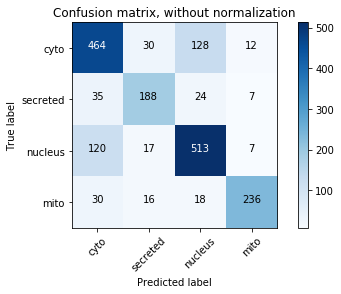

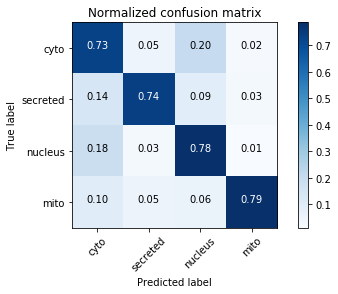

In [42]:
#confusion matrix
target_names= ['cyto','secreted','nucleus','mito']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_eval, pred_label)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [43]:
#scores
print(classification_report(y_eval, pred_label,  
             target_names= ['cyto','secreted','nucleus','mito']))

             precision    recall  f1-score   support

       cyto       0.71      0.73      0.72       634
   secreted       0.75      0.74      0.74       254
    nucleus       0.75      0.78      0.77       657
       mito       0.90      0.79      0.84       300

avg / total       0.76      0.76      0.76      1845



Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7fa99413d7f0>>
Traceback (most recent call last):
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/xgboost/core.py", line 368, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


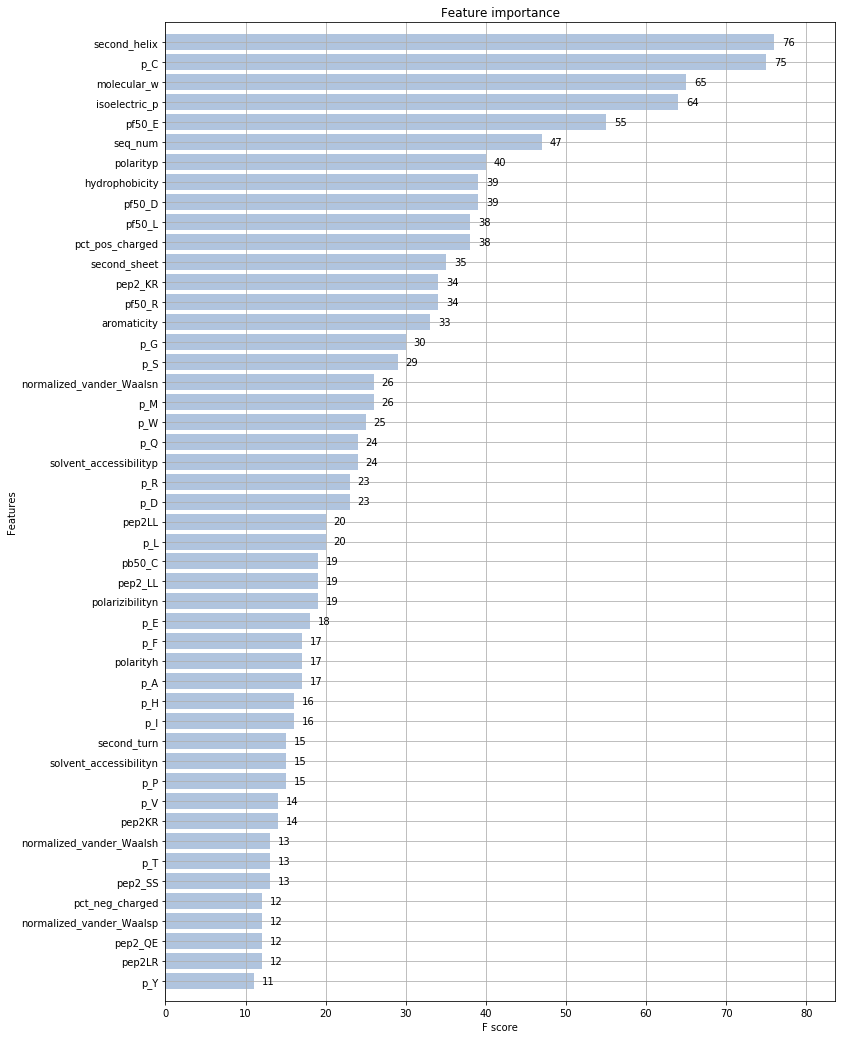

In [45]:
#features importance
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=48, height=0.8,ax=ax, color="lightsteelblue")
plt.show()

#

Text(0.5,1,'isoelectric_p')

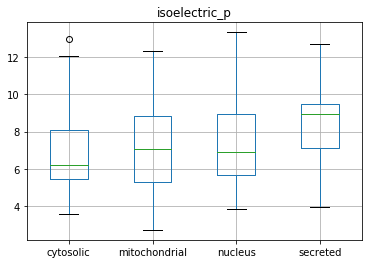

In [76]:
df_train = X_train.join(y_train)
name = 'isoelectric_p'#second_helix'#'p_C'#'molecular_w'#
y0 = df_train[df_train['label']==0][name]
y2 = df_train[df_train['label']==2][name]
y1 = df_train[df_train['label']==1][name]
y3 = df_train[df_train['label']==3][name]
y = pd.DataFrame({'cytosolic':y0,
                  'secreted':y1,
             'nucleus':y2,
                 "mitochondrial":y3})
y.boxplot()
plt.title(name)

Text(0.5,1,'isoelectric_p')

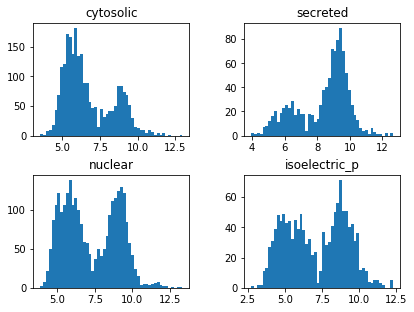

In [77]:
plt.subplot(221)
plt.hist(y0,50)
plt.title('cytosolic')
plt.subplot(222)
plt.hist(y1,50)
plt.title('secreted')
plt.subplot(223)
plt.hist(y2,50)
plt.title('nuclear')
plt.subplot(224)
plt.hist(y3,50)
plt.title('mitochondrial')
plt.subplots_adjust(top=0.92, bottom=0.00, left=0.10, right=0.95, hspace=0.35,
                    wspace=0.35)
plt.title(name)

In [ ]:
#tuning parameters:GridSearchCV to findout best hyperparameters
'''
model = XGBClassifier()
param_grid = {
    'max_depth':np.arange(3,8,2),
    'min_child_weight': np.arange(1,8,2),
    'learning_rate':[0.0001,0.001,0.01,0.1,0.2,0.3],
    'gamma':[i/10.0 for i in range(0,5)],
    'subsample':np.arange(0,1,0.2),
    'n_estimators':[50,100,300]
}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
'''